## test

In [1]:
import numpy as np
try:
    from matplotrender.src.matplotrender import *
except:
    #!pip install git+https://github.com/chacorp/matplotrender.git
    from matplotrender import *
    
from utils.ict_face_model import ICT_face_model
from utils.util import *

# import meshplot as mp

In [2]:
src_mesh = EasyDict()

src_mesh.v, src_mesh.f = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
print('\t src vertices:', src_mesh.v.shape, '\t faces:', src_mesh.f.shape) # (11248, 3) (22288, 3)


	 src vertices: (11248, 3) 	 faces: (22288, 3)


In [6]:
src_mesh.f 

array([[  873,    11,   870],
       [  870,    11,  1492],
       [   17,  1189,  1190],
       ...,
       [11154, 11039, 11040],
       [11155, 11043, 11039],
       [11156,  9679, 11043]])

In [ ]:
# print(src_mesh.v.min(0), src_mesh.v.max(0))


# large cube
control_mesh = EasyDict()
control_mesh.f = np.array([
    [0,2,3,1],
    [0,1,5,4],
    [1,3,7,5],
    [3,2,6,7],
    [2,0,4,6],
    [5,7,6,4],
])
control_mesh.f = control_mesh.f[:,[[3,2,1],[3,1,0]]].reshape(-1, 3)
# control_mesh.f = control_mesh.f[:,[[1,2,3],[0,1,3]]].transpose(1, 0, 2).reshape(-1, 3)
# control_mesh.f = control_mesh.f[:,::-1]
# print(control_mesh.f)
# control_mesh.f 

control_mesh.v = np.zeros((8,3))

## X, Y, Z
control_mesh.v[0] = src_mesh.v.max(0)
control_mesh.v[1,0], control_mesh.v[1,1], control_mesh.v[1,2] = src_mesh.v.max(0)[0], src_mesh.v.max(0)[1], src_mesh.v.min(0)[2]
control_mesh.v[2,0], control_mesh.v[2,1], control_mesh.v[2,2] = src_mesh.v.min(0)[0], src_mesh.v.max(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[3,0], control_mesh.v[3,1], control_mesh.v[3,2] = src_mesh.v.min(0)[0], src_mesh.v.max(0)[1], src_mesh.v.min(0)[2]

control_mesh.v[4,0], control_mesh.v[4,1], control_mesh.v[4,2] = src_mesh.v.max(0)[0], src_mesh.v.min(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[5,0], control_mesh.v[5,1], control_mesh.v[5,2] = src_mesh.v.max(0)[0], src_mesh.v.min(0)[1], src_mesh.v.min(0)[2]
control_mesh.v[6,0], control_mesh.v[6,1], control_mesh.v[6,2] = src_mesh.v.min(0)[0], src_mesh.v.min(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[7] = src_mesh.v.min(0)

# control_mesh.v[:,1]=control_mesh.v[:,1]*1.05
control_mesh.v=control_mesh.v*1.1


control_mesh_v2 = control_mesh.v.copy()
control_mesh_v2[0:4, 0] = control_mesh_v2[0:4, 0]+0.8


[-1.18697512 -1.81234658 -1.37132633] [1.12008107 1.3834517  0.78344184]
[[1 3 2]
 [1 2 0]
 [4 5 1]
 [4 1 0]
 [5 7 3]
 [5 3 1]
 [7 6 2]
 [7 2 3]
 [6 4 0]
 [6 0 2]
 [4 6 7]
 [4 7 5]]


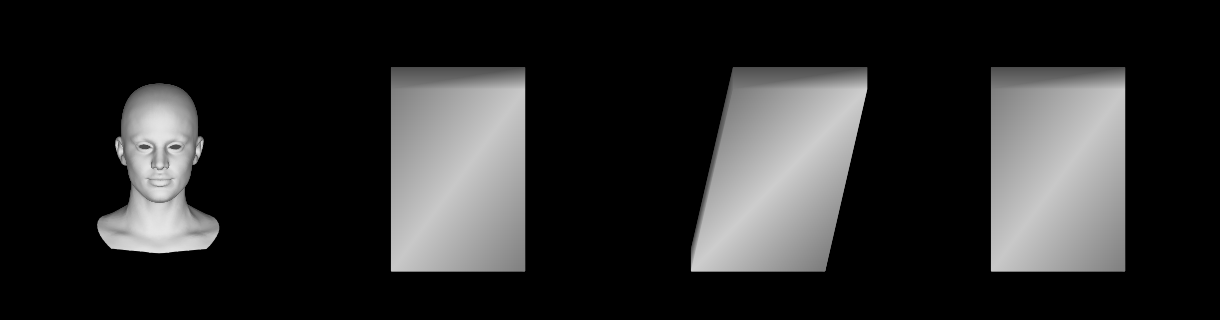

In [286]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

v_list=[ src_mesh.v, control_mesh.v, control_mesh_v2, np.r_[src_mesh.v, control_mesh.v]]
f_list=[ src_mesh.f, control_mesh.f, control_mesh.f, np.r_[src_mesh.f, control_mesh.f+src_mesh.f.max()+1]]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

In [229]:
control_mesh.f

array([[1, 3, 2],
       [1, 2, 0],
       [4, 5, 1],
       [4, 1, 0],
       [5, 7, 3],
       [5, 3, 1],
       [7, 6, 2],
       [7, 2, 3],
       [6, 4, 0],
       [6, 0, 2],
       [4, 6, 7],
       [4, 7, 5]])

In [ ]:
for vdx, x in enumerate(src_mesh.v):
    Uj = np.zeros_like((control_mesh.v))
    dj = np.zeros(control_mesh.v.shape[0])

    for jdx, Pj in enumerate(control_mesh.v):
        
        Pj_v = Pj - x
        
        dj[jdx] = np.linalg.norm(Pj_v)
            
        Uj[jdx] = Pj_v / dj[jdx]
    for tri_idx in control_mesh.f:
        
        determinant = np.linalg.det(Uj[tri_idx])
        print(np.linalg.det(Uj[tri_idx]), np.linalg.det(Uj[tri_idx].transpose(1,0)))
        break
    break

0.5092853672512292 0.5092853672512291


In [ ]:
def MVC(src_mesh, control_mesh, _func_=None, eps=1e-8):
    
    if _func_ is None:
        _func_ = control_mesh.v

    # new_v = np.zeros_like(src_mesh.v)
    
    new_F = np.zeros_like(src_mesh.v)
    new_W = np.zeros(src_mesh.v.shape[0])
    
    for vdx, x in enumerate(src_mesh.v):
        
        Uj = np.zeros_like((control_mesh.v))
        dj = np.zeros(control_mesh.v.shape[0])
        
        for jdx, Pj in enumerate(control_mesh.v):
            
            Pj_v = Pj - x
            
            dj[jdx] = np.linalg.norm(Pj_v)
            
            if dj[jdx] < eps:
                new_v[vdx] = _func_[jdx]
                
            Uj[jdx] = Pj_v / dj[jdx]
        
        # Wj = np.zeros_like((control_mesh.v))
        for tri_idx in control_mesh.f:
            
            f0, f1, f2 = _func_[tri_idx]
            i0, i1, i2 = tri_idx
            
            # print(i0, i1, i2)
            d0 = dj[i0]
            d1 = dj[i1]
            d2 = dj[i2]
            
            L0 = np.linalg.norm(Uj[i1] - Uj[i2])
            L1 = np.linalg.norm(Uj[i2] - Uj[i0])
            L2 = np.linalg.norm(Uj[i0] - Uj[i1])
            
            theta0 = 2 * np.arcsin(L0 * 0.5)
            theta1 = 2 * np.arcsin(L1 * 0.5)
            theta2 = 2 * np.arcsin(L2 * 0.5)
            
            h = (theta0 + theta1 + theta2) * 0.5
            
            if abs(np.pi - h) < eps:
                W0 = np.sin(theta0)*d2*d1
                W1 = np.sin(theta0)*d2*d1
                W2 = np.sin(theta0)*d2*d1
                
                new_F[vdx] += (W0 * f0) + (W1 * f1) + (W2 * f2)
                new_W[vdx] += W0 + W1 + W2
            else:
                s_theta0 = np.sin(theta0)
                s_theta1 = np.sin(theta1)
                s_theta2 = np.sin(theta2)
                
                c0 = (2.0*np.sin(h)*np.sin(h-theta0)) / (s_theta1*s_theta2) - 1
                c1 = (2.0*np.sin(h)*np.sin(h-theta1)) / (s_theta2*s_theta0) - 1
                c2 = (2.0*np.sin(h)*np.sin(h-theta2)) / (s_theta0*s_theta1) - 1
                
                determinant = np.linalg.det(Uj[tri_idx])
                sign = -1 if determinant < 0 else 1
                
                s0 = sign * np.sqrt(1-c0**2)
                s1 = sign * np.sqrt(1-c1**2)
                s2 = sign * np.sqrt(1-c2**2)
                
                W0 = 0 if s0 == 0 else (theta0 - c1*theta2 - c2*theta1) / (2 * s1 * s_theta2 * d0)
                W1 = 0 if s1 == 0 else (theta1 - c2*theta0 - c0*theta2) / (2 * s2 * s_theta0 * d1)
                W2 = 0 if s2 == 0 else (theta2 - c0*theta1 - c1*theta0) / (2 * s0 * s_theta1 * d2)
                    
                new_F[vdx] += (W0 * f0) + (W1 * f1) + (W2 * f2)
                new_W[vdx] += W0 + W1 + W2
    return new_F / new_W[..., None]


In [287]:

new_v = MVC(src_mesh, control_mesh, control_mesh_v2)

In [271]:
print(src_mesh.v.min(0), src_mesh.v.max(0))
print(new_v.min(0), new_v.max(0))

[-1.18697512 -1.81234658 -1.37132633] [1.12008107 1.3834517  0.78344184]
[-1.18697512 -1.77110273 -1.37132633] [1.12008107 2.15196828 0.78344184]


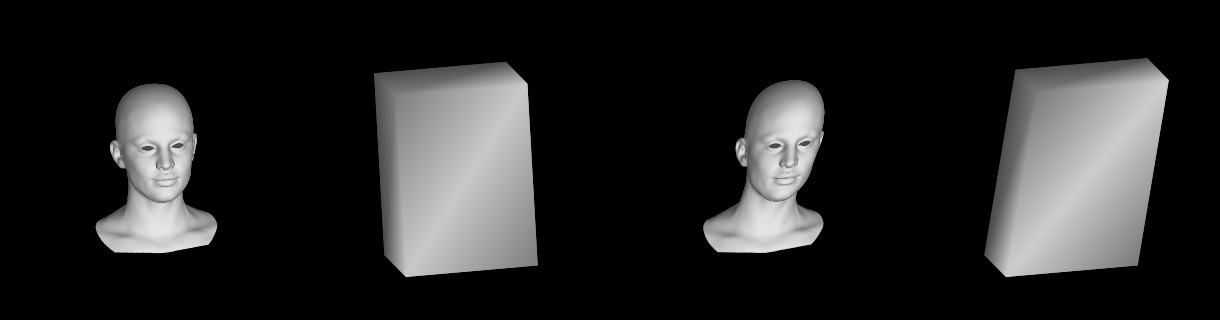

In [289]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        src_mesh.v, 
        control_mesh.v, 
        new_v, 
        control_mesh_v2
        ]
f_list=[ 
        src_mesh.f,
        control_mesh.f,
        src_mesh.f,
        control_mesh.f
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,10,5] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

In [107]:
import meshplot as mp

ModuleNotFoundError: No module named 'meshplot'

In [85]:
new_v.shape

(11248, 3)

In [31]:
# markers
src_m = np.array(
    [
        1225,  1888,  1052,   367,  1719,  1722,  2199,  1447,   966,
        3661,  4390,  3927,  3924,  2608,  3272,  4088,  3443,   268,
         493,  1914,  2044,  1401,  3615,  4240,  4114,  2734,  2509,
         978,  4527,  4942,  4857,  1140,  2075,  1147,  4269,  3360,
        1507,  1542,  1537,  1528,  1518,  1511,  3742,  3751,  3756,
        3721,  3725,  3732,  5708,  5695,  2081,     0,  4275,  6200,
        6213,  6346,  6461,  5518,  5957,  5841,  5702,  5711,  5533,
        6216,  6207,  6470,  5517,  5966, 10760, 11064, 10678, 10527,
        3607,  9584,  7571,  6844, 10295,  9461
    ]
)
tgt_m = np.array(
    [
        449,  475,  131,  114,  296,  649,  310,  551,  357, 1342, 1111,
       1438, 1096,  931,  949, 1263, 1253,  368,  379,  152,   40,  714,
       1497,  848,  969, 1176,  841,  361, 1618, 1723, 1707,  440,  745,
          3, 1231, 1229,  193,  384,  224,  337,  212,  326,  849, 1028,
       1070, 1002, 1125, 1018, 1931,   57,  742,    0, 1526,  865, 2049,
       2083, 2109, 2100, 1976, 1952, 1914, 1918, 1867, 2036, 2034, 2111,
       1863, 1973, 3523, 3641, 3473, 3422, 1322, 3301, 2684, 2174, 3361,
       3145
    ]
)

# np.array(src_m)

## Run

In [32]:
mesh = corr_system(src_mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=1, Wi=0.001, Wc=0, Wm=1, show=False, mode=1)

In [33]:
def render_shortcut(src_mesh, mesh, tgt_mesh):
    mesh_scale = .65
    v_list1=[
            src_mesh.v,
            mesh.v,
            tgt_mesh.v,
        ]
    f_list1=[
            src_mesh.f,
            mesh.f,
            tgt_mesh.f,
        ]
    rot_list=[ [0,0,0] ]*len(v_list1)
    plot_mesh_gouraud(v_list1, f_list1, 
                        # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                        mesh_scale=mesh_scale,
                        rot_list=rot_list, size=4, mode='shade')

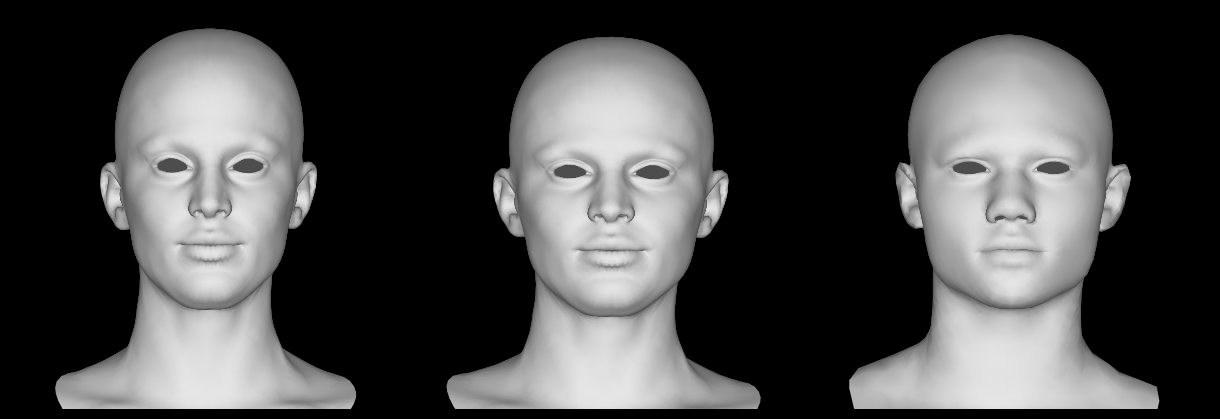

In [34]:
render_shortcut(src_mesh,mesh,tgt_mesh)

In [ ]:
for wc in np.linspace(1, 5000, 4):
    mesh = corr_system(mesh, tgt_mesh, src_m, tgt_m, num_iter=1, Ws=1, Wi=0.001, Wc=wc, Wm=1, show=False, mode=1)
    render_shortcut(src_mesh,mesh,tgt_mesh)

In [16]:
np.linspace(1, 5000, 4)

array([1.00000000e+00, 1.66733333e+03, 3.33366667e+03, 5.00000000e+03])

# mean

In [25]:
import numpy as np
from matplotrender import *

mf_id_verts_train = np.load('exp_data/id_verts_train.npy', allow_pickle=True)
mf_id_verts_test = np.load('exp_data/id_verts_test.npy', allow_pickle=True)
mf_id_verts_val = np.load('exp_data/id_verts_val.npy', allow_pickle=True)

mf_all = np.vstack((mf_id_verts_train, mf_id_verts_val, mf_id_verts_test))
mf_all_mean = mf_all.mean(0)

mf_standardization = np.load('exp_data/mf_standardization.npy', allow_pickle=True).item()

print(mf_all_mean.shape)
# k=10
# mesh_scale = .65


(5223, 3)


In [27]:

qwe = trimesh.Trimesh(vertices=mf_id_verts_train[0], faces=mf_standardization["new_f"])
_ = qwe.export("multiface_train_0_mean_std_mesh.obj")

In [22]:
import pickle

with open('exp_data/biwi_templates_align_deci.pkl', 'rb') as f:
    biwi_templates_align_deci = pickle.load(f)
biwi_all = 0
count = 0
for id_key in biwi_templates_align_deci.keys():
    if id_key == "face":
        continue
    count +=1
    biwi_all+=biwi_templates_align_deci[id_key]
biwi_all /= count

with open('exp_data/voca_templates.pkl', 'rb') as f:
    voca_templates = pickle.load(f)
    
voca_all = 0
count = 0
for id_key in voca_templates.keys():
    if id_key == "face":
        continue
    count +=1
    voca_all+=voca_templates[id_key]
voca_all /= count
    

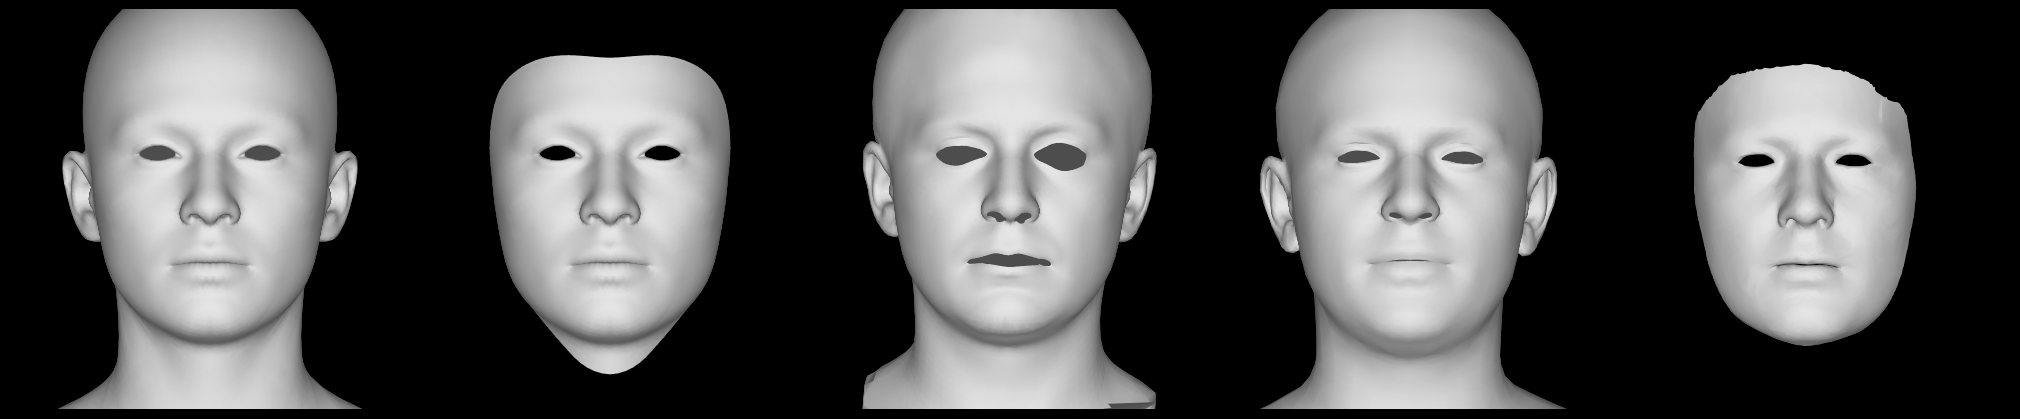

In [23]:
ict = ICT_face_model()
ict_narrow = ICT_face_model(narrow_only=True)
v_list1=[ 
        ict.neutral_verts,
        ict_narrow.neutral_verts,
        mf_all_mean,
        voca_all,
        biwi_all
    ]
f_list1=[
        ict.faces, 
        ict_narrow.faces, 
        mf_standardization["new_f"],
        voca_templates["face"],
        biwi_templates_align_deci["face"]
    ]
rot_list=[ [0,0,0] ]*len(v_list1)
plot_mesh_gouraud(v_list1, f_list1, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=0.8,
                     rot_list=rot_list, size=4, mode='shade')

In [10]:
qwe = trimesh.Trimesh(vertices=mf_all_mean, faces=mf_standardization["new_f"])
_ = qwe.export("multiface_mean_std_mesh.obj")

In [18]:
qwe = trimesh.Trimesh(vertices=ict.neutral_verts, faces=ict.faces)
_ = qwe.export("ict_full_head.obj")

qwe = trimesh.Trimesh(vertices=ict_narrow.neutral_verts, faces=ict_narrow.faces)
_ = qwe.export("ict_narrow_face.obj")

In [24]:
qwe = trimesh.Trimesh(vertices=voca_all, faces=voca_templates["face"],)
_ = qwe.export("voca_templates_mean_std.obj")

qwe = trimesh.Trimesh(vertices=biwi_all, faces=biwi_templates_align_deci["face"])
_ = qwe.export("biwi_templates_align_deci_mean.obj")